## Thêm thư viện

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from IPython.display import display
import joblib

## Cấu hình

In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/PTDLKD/Datasets/Processed/6_2_2'
coins = ['btc', 'eth', 'bnb']
time_step = 100
results = []  # Lưu kết quả mỗi coin

## Hàm tính đặc trưng kĩ thuật

In [ ]:
def add_technical_features(df):
    df['MA_5'] = df['Price'].rolling(window=5).mean()
    df['MA_10'] = df['Price'].rolling(window=10).mean()
    df['RSI_14'] = compute_rsi(df['Price'], 14)
    df['Volatility_5'] = df['Price'].rolling(window=5).std()
    return df.dropna()

In [ ]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / (loss + 1e-9)
    return 100 - (100 / (1 + rs))

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

## Hàm tạo dữ liệu chuỗi nhiều đặc trưng

In [ ]:
def create_multifeature_dataset(df, target_col, time_step):
    feature_cols = df.columns.drop('Date')
    X, y = [], []
    for i in range(len(df) - time_step):
        features = df[feature_cols].iloc[i:i+time_step].values.flatten()
        X.append(features)
        y.append(df[target_col].iloc[i + time_step])
    return pd.DataFrame(X), pd.Series(y)

## Hàm dự đoán tương lai

In [ ]:
def forecast_future(model, last_seq_df, time_step, days):
    forecast = []
    input_seq = last_seq_df.copy()
    for _ in range(days):
        input_flat = input_seq.iloc[-time_step:].values.flatten().reshape(1, -1)
        pred = model.predict(input_flat)[0]
        next_row = input_seq.iloc[-1:].copy()
        next_row['Price'] = pred
        next_row['MA_5'] = input_seq['Price'].iloc[-5:].mean()
        next_row['MA_10'] = input_seq['Price'].iloc[-10:].mean()
        next_row['RSI_14'] = compute_rsi(input_seq['Price'], 14).iloc[-1]
        next_row['Volatility_5'] = input_seq['Price'].iloc[-5:].std()
        input_seq = pd.concat([input_seq, next_row], ignore_index=True)
        forecast.append(pred)
    return forecast

## Xây dựng mô hình cho cả ba bộ dữ liệu


=====================  BTC =====================
Train: (1029, 1000), Val: (267, 1000), Test: (269, 1000)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Test       : RMSE=24801.8925, MAE=18793.6628, MAPE=20.58%, R²=-1.0983


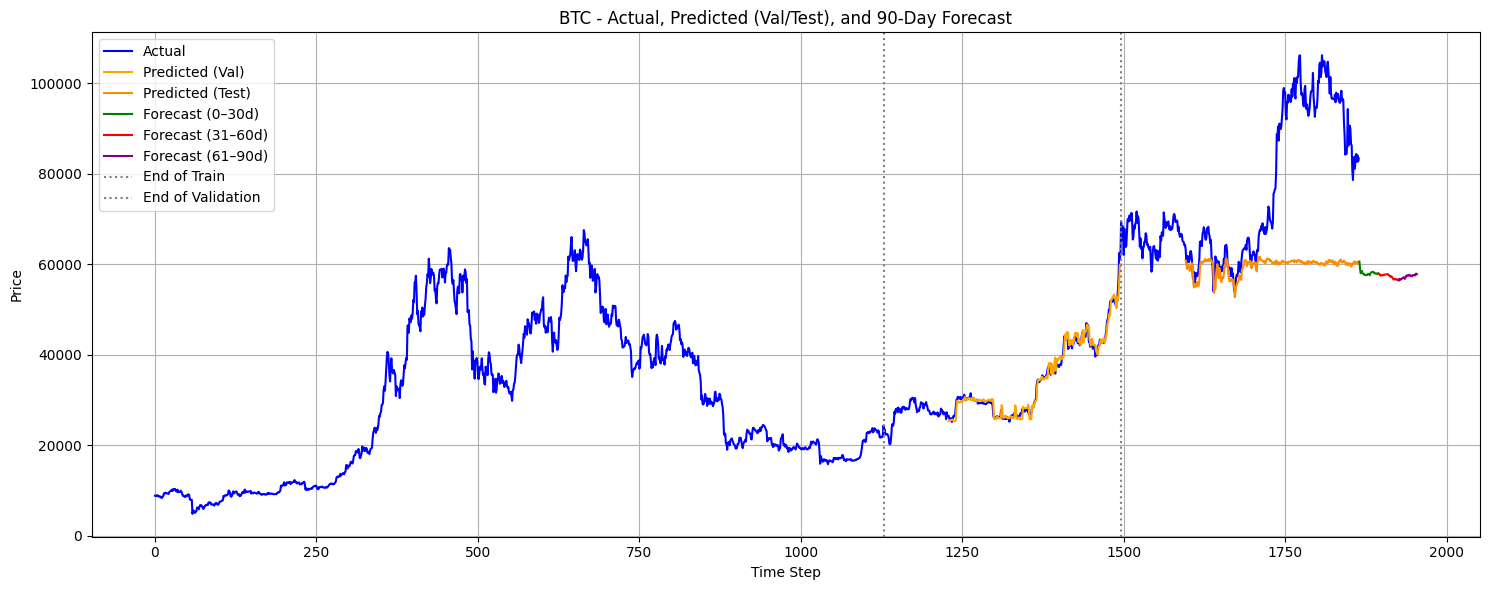


=====================  ETH =====================
Train: (1030, 1000), Val: (268, 1000), Test: (268, 1000)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Test       : RMSE=130.3498, MAE=98.4687, MAPE=3.36%, R²=0.9331


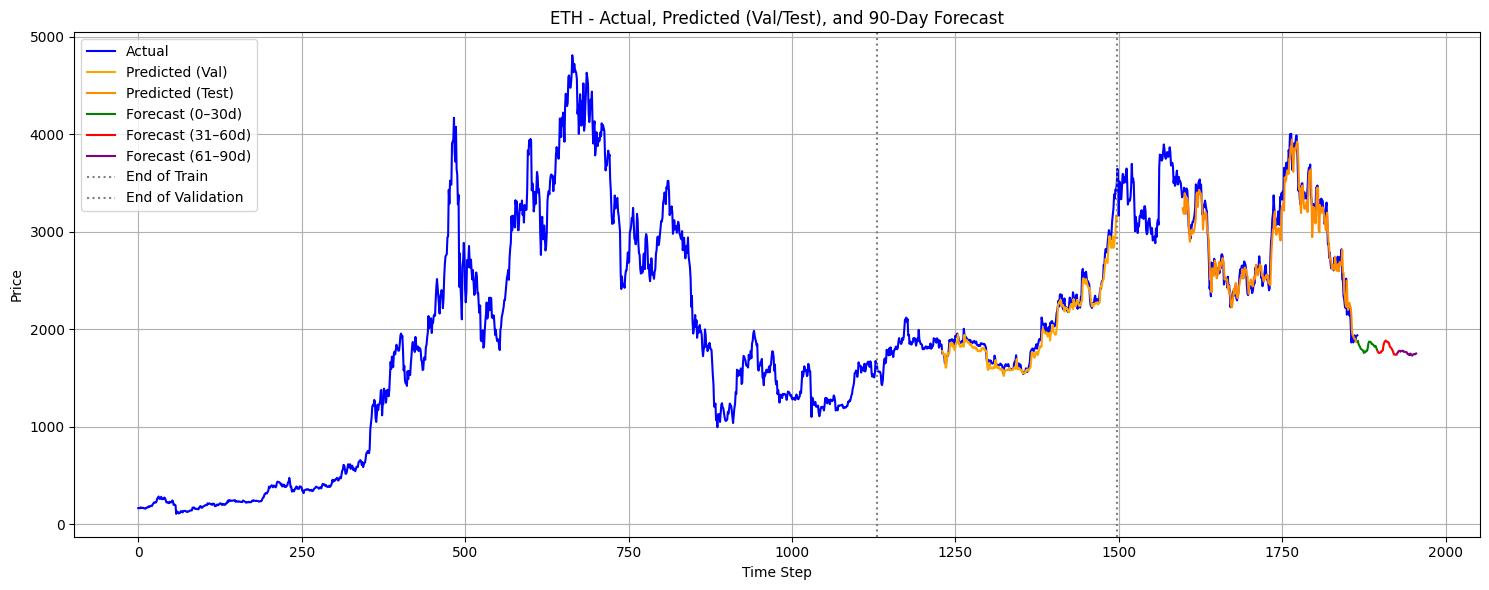


=====================  BNB =====================
Train: (1030, 1000), Val: (268, 1000), Test: (268, 1000)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Test       : RMSE=67.7676, MAE=50.1161, MAPE=7.68%, R²=-0.1095


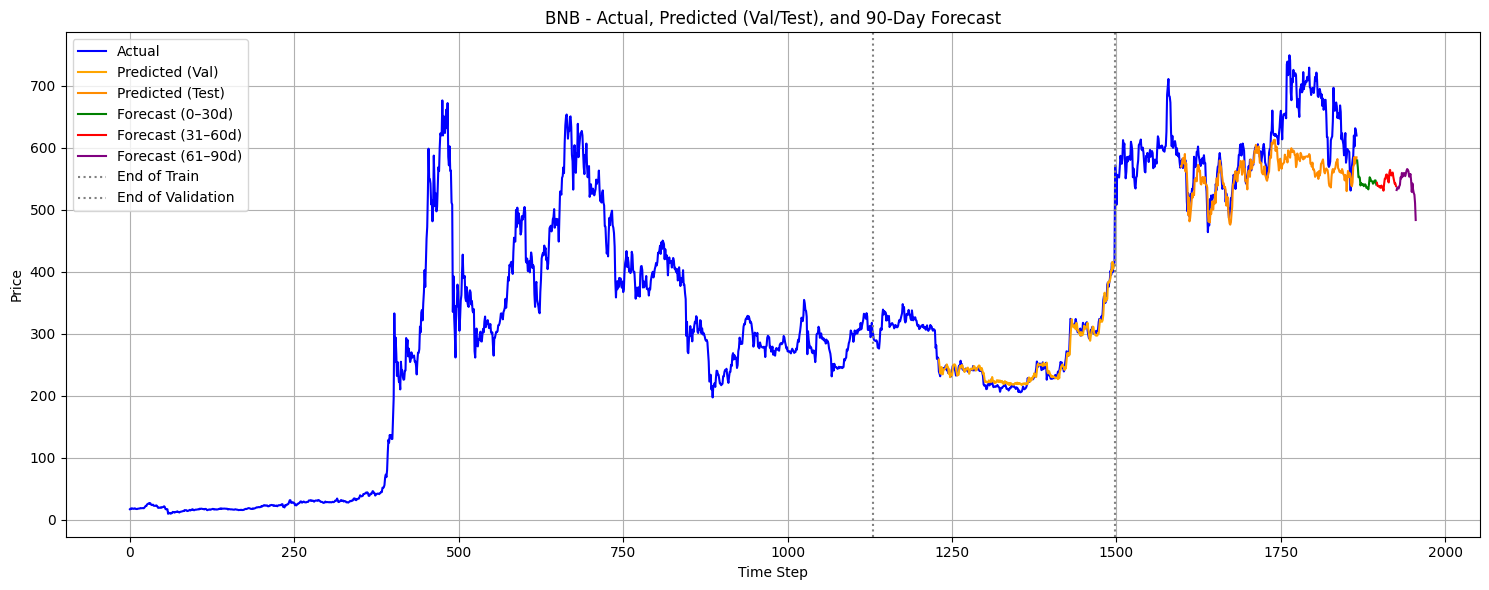

In [ ]:
for coin in coins:
    print(f"\n=====================  {coin.upper()} =====================")

    # Load và xử lý
    df_train = pd.read_csv(f"{base_path}/{coin}_train.csv")
    df_val = pd.read_csv(f"{base_path}/{coin}_val.csv")
    df_test = pd.read_csv(f"{base_path}/{coin}_test.csv")

    for df in [df_train, df_val, df_test]:
        df['Date'] = pd.to_datetime(df['Date'])
        df.rename(columns={'Vol.': 'Volume'}, inplace=True)
       df['Change'] = df['Change %'].astype(str).str.replace('%', '').astype(float) / 100
        df.drop(columns=['Change %'], inplace=True)
        df.sort_values('Date', inplace=True)

    df_train = add_technical_features(df_train)
    df_val = add_technical_features(df_val)
    df_test = add_technical_features(df_test)

    X_train, y_train = create_multifeature_dataset(df_train, 'Price', time_step)
    X_val, y_val = create_multifeature_dataset(df_val, 'Price', time_step)
    X_test, y_test = create_multifeature_dataset(df_test, 'Price', time_step)

    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    # === GridSearchCV ===
    param_grid = {
        'n_estimators': [200, 500],
        'max_depth': [4, 6],
        'learning_rate': [0.01, 0.05],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
    }

    base_model = XGBRegressor(
        objective="reg:squarederror",
        reg_lambda=1, reg_alpha=0.5,
        random_state=42, eval_metric='rmse')

    grid = GridSearchCV(base_model, param_grid,
                    scoring='neg_mean_squared_error',
                    cv=3, verbose=1, n_jobs=-1)
    grid.fit(X_train, y_train)
    model = grid.best_estimator_

    #Dự đoán trên VAL
    val_preds = model.predict(X_val)

    # Dự đoán chỉ trên TEST
    test_preds = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
    mae_test = mean_absolute_error(y_test, test_preds)
    r2_test = r2_score(y_test, test_preds)
    mape_test = mean_absolute_percentage_error(y_test, test_preds)

    results.append({
        'Coin': coin.upper(),
        'RMSE_Test': rmse_test,
        'MAE_Test': mae_test,
        'MAPE_Test': mape_test,
        'R2_Test': r2_test
    })

    print(f"Test       : RMSE={rmse_test:.4f}, MAE={mae_test:.4f}, MAPE={mape_test:.2f}%, R²={r2_test:.4f}")

    # Dự báo tương lai
    df_all = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)
    df_all = df_all.drop(columns='Date')
    future_90 = forecast_future(model, df_all.copy(), time_step, 90)

    # Biểu đồ
    # Lấy dữ liệu giá thực tế từ các DataFrame gốc
    full_actual = pd.concat([df_train, df_val, df_test])['Price'].values

    # Định vị trí bắt đầu
    val_pred_start = len(df_train) + time_step
    test_pred_start = len(df_train) + len(df_val) + time_step

    plt.figure(figsize=(15, 6))

    # Actual
    plt.plot(range(len(full_actual)), full_actual, label='Actual', color='blue')

    # Predicted (Val)
    plt.plot(
        range(val_pred_start, val_pred_start + len(val_preds)),
        val_preds,
        label='Predicted (Val)',
        color='orange'
    )

    # Predicted (Test)
    plt.plot(
        range(test_pred_start, test_pred_start + len(test_preds)),
        test_preds,
        label='Predicted (Test)',
        color='darkorange'
    )

    # Forecast giữ nguyên
    forecast_start = len(full_actual)
    plt.plot(range(forecast_start, forecast_start + 30), future_90[:30], label='Forecast (0–30d)', color='green')
    plt.plot(range(forecast_start + 30, forecast_start + 60), future_90[30:60], label='Forecast (31–60d)', color='red')
    plt.plot(range(forecast_start + 60, forecast_start + 90), future_90[60:], label='Forecast (61–90d)', color='purple')

    # Vạch phân chia
    plt.axvline(x=len(df_train), color='gray', linestyle=':', label='End of Train')
    plt.axvline(x=len(df_train) + len(df_val), color='gray', linestyle=':', label='End of Validation')

    plt.title(f"{coin.upper()} - Actual, Predicted (Val/Test), and 90-Day Forecast")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    joblib.dump(model, f"{coin}_xgb_model_grid.pkl")

## Kết quả tổng hợp

In [ ]:
results_df = pd.DataFrame(results)
print("\n==== Tổng hợp kết quả đánh giá ====")
display(results_df)


==== Tổng hợp kết quả đánh giá ====


,Coin,RMSE_Test,MAE_Test,MAPE_Test,R2_Test
0,BTC,24801.892532,18793.662817,20.577785,-1.098270
1,ETH,130.349848,98.468692,3.355654,0.933081
2,BNB,67.767554,50.116134,7.683761,-0.109512
